<a href="https://colab.research.google.com/github/Crisitunity-Lab/ARDC-Project/blob/main/Notebook/Production/Llama2_prod_r13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Llama2 Production

SUMA 12/10/2023

#Instructions

Running code on Google Colab
1.   Create HuggingFace account
2.   Gain access to model: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
3.   Create folder 'data' in project folder on personal Google Drive
4.   Save data set CrisiLexT26 in folder 'data'
5.   Data sourced from: https://crisislex.org/data-collections.html#CrisisLexT26
6.   Mount Google Drive
7.   Update code with Paths
8.   Set system up as per steps below
9.   Run Experiments
10.  Evaluate

## Setup

In [1]:
# Install Transformer package
!pip install -q transformers einops accelerate langchain bitsandbytes
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.2 MB/s eta 0:00:00


In [2]:
# Import Packages
from langchain import PromptTemplate,  LLMChain
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import pandas as pd
import numpy as np
import json
import os
import csv
import time
import re
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Mounting GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Prerequisites

To load our desired model, `meta-llama/Llama-2-7b-chat-hf`, we first need to authenticate ourselves on Hugging Face. This ensures we have the correct permissions to fetch the model.

1. Gain access to the model on Hugging Face: [Link](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).
2. Use the Hugging Face CLI to login and verify your authentication status.


In [4]:
# Logging onto HuggingFace
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Preparing data

In [5]:
%%time
# Read (timestamps) - dont run if timestamps not needed

# Path to the main folder
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Function to process CSV files in a folder
def process_folder(folder_path):
    dfs = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv') and 'period' in file.lower():
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                dfs.append(df)
    return dfs

# Read and process each subfolder
combined_data = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        subfolder_data = process_folder(subfolder_path)
        combined_data.extend(subfolder_data)

# Concatenate all data into one DataFrame
combined_df_p = pd.concat(combined_data, ignore_index=True)


# Remove spaces from column names
combined_df_p.columns = combined_df_p.columns.str.replace(' ', '')

# Rename Columns in prep for left join
combined_df_p.rename(columns={'Tweet-ID': 'Tweet ID'}, inplace=True)

# # Save the combined DataFrame to a CSV file
# output_file = 'combined_data.csv'
# combined_df.to_csv(output_file, index=False)

print(f"Combined timestamps read")


Combined timestamps read
CPU times: user 289 ms, sys: 71.9 ms, total: 361 ms
Wall time: 9.44 s


In [6]:
%%time
# Read tweets

# Path to the main folder
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Function to process CSV files in a folder, add folder name as label, and add subfolder name as a column
def process_folder(folder_path, label, subfolder_name):
    dfs = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv') and 'labeled' in file.lower():
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                df['Label'] = label
                df['subfolder_name'] = subfolder_name  # Add subfolder name as a column
                dfs.append(df)
    return dfs

# Read and process each subfolder
combined_data = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        label = subfolder
        subfolder_data = process_folder(subfolder_path, label, subfolder)
        combined_data.extend(subfolder_data)

# Concatenate all data into one DataFrame
combined_df_l = pd.concat(combined_data, ignore_index=True)

# Print the first few rows of the combined DataFrame
print(f"Combined tweets read")
combined_df_l.head(10)


Combined tweets read
CPU times: user 231 ms, sys: 17.1 ms, total: 249 ms
Wall time: 7.25 s


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,subfolder_name
0,347686624563429378,"RT @CBCAlerts: Canmore, Alta. declares state o...",Media,Affected individuals,Related and informative,2013_Alberta_floods,2013_Alberta_floods
1,347766337344503808,RT @GlobalCalgary: If you are in #Canmore and ...,Media,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods
2,347779159327637504,RT @metrocalgary: UPDATE: Latest from the @cit...,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods
3,347783236191129600,RT @GlobalCalgary: GALLERY: Incredible photos ...,Media,Not applicable,Related and informative,2013_Alberta_floods,2013_Alberta_floods
4,347793432514801665,RT @nenshi: Major risk of flooding in Calgary....,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods
5,347793818403344384,RT @weathernetwork: RT: Residents of #HighRive...,Media,Affected individuals,Related and informative,2013_Alberta_floods,2013_Alberta_floods
6,347802211222433792,RT @BrockWHarrison: . @ElectDanielle and other...,NGOs,Affected individuals,Related and informative,2013_Alberta_floods,2013_Alberta_floods
7,347804916514951168,Lots of #abflood updates on our liveblog http:...,Media,Other Useful Information,Related and informative,2013_Alberta_floods,2013_Alberta_floods
8,347808955663257600,RT @aldjohnmar: Our first Emergency Shelter wi...,NGOs,Infrastructure and utilities,Related and informative,2013_Alberta_floods,2013_Alberta_floods
9,347812738900320256,'Move to high ground:' Rapid flooding forces e...,Media,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods


In [7]:
%%time
# Extract earliest timestamp

# Convert it to datetime first
combined_df_p['Timestamp'] = pd.to_datetime(combined_df_p['Timestamp'])

# Group by 'Tweet-ID' and aggregate to find the earliest timestamp
earliest_timestamps = combined_df_p.groupby('Tweet ID')['Timestamp'].agg('min').reset_index()

# Display or use the resulting DataFrame 'earliest_timestamps'
# print(earliest_timestamps)

CPU times: user 44.5 s, sys: 78.4 ms, total: 44.6 s
Wall time: 44.9 s


In [8]:
%%time
# Left join

# Perform a left join on 'Tweet ID'
result_df = combined_df_l.merge(earliest_timestamps, on='Tweet ID', how='left')

# Display
# print(result_df)
# result_df.shape
result_df.head()

CPU times: user 47.7 ms, sys: 7.04 ms, total: 54.8 ms
Wall time: 61 ms


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,subfolder_name,Timestamp
0,347686624563429378,"RT @CBCAlerts: Canmore, Alta. declares state o...",Media,Affected individuals,Related and informative,2013_Alberta_floods,2013_Alberta_floods,2013-06-20 12:05:25+00:00
1,347766337344503808,RT @GlobalCalgary: If you are in #Canmore and ...,Media,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods,2013-06-20 17:22:10+00:00
2,347779159327637504,RT @metrocalgary: UPDATE: Latest from the @cit...,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods,2013-06-20 18:13:07+00:00
3,347783236191129600,RT @GlobalCalgary: GALLERY: Incredible photos ...,Media,Not applicable,Related and informative,2013_Alberta_floods,2013_Alberta_floods,2013-06-20 18:29:19+00:00
4,347793432514801665,RT @nenshi: Major risk of flooding in Calgary....,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013_Alberta_floods,2013-06-20 19:09:50+00:00


In [9]:
%%time
# Read

# Define the main folder path
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Initialize empty lists to store the extracted data
subfolder_names = []
names = []
start_days = []
durations = []
countries = []
location_descriptions = []
sub_categories = []
types = []

# Loop through the subfolders
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        json_files = [f for f in os.listdir(subfolder_path) if f.endswith('.json')]

        # Loop through JSON files in the subfolder
        for json_file in json_files:
            json_path = os.path.join(subfolder_path, json_file)

            # Read the JSON file
            with open(json_path, 'r') as f:
                data = json.load(f)

                # Extract the required information
                subfolder_names.append(subfolder)
                names.append(data['name'])
                start_days.append(data['time']['start_day'])
                durations.append(data['time']['duration'])
                countries.append(data['location']['country'])
                location_descriptions.append(data['location']['location_description'])
                sub_categories.append(data['categorization']['sub_category'])
                types.append(data['categorization']['type'])

# Create a DataFrame from the extracted data
df_annotation = pd.DataFrame({
    'subfolder_name': subfolder_names,
    'name': names,
    'start_day': start_days,
    'duration': durations,
    'country': countries,
    'location_description': location_descriptions,
    'sub_category': sub_categories,
    'type': types
})

# Display the DataFrame
df_annotation.head()


CPU times: user 36.7 ms, sys: 10.1 ms, total: 46.9 ms
Wall time: 8.22 s


,subfolder_name,name,start_day,duration,country,location_description,sub_category,type
0,2013_Alberta_floods,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods
1,2013_Glasgow_helicopter_crash,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash
2,2012_Costa_Rica_earthquake,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
3,2013_Manila_floods,Manila Floods,2013-08-17,11,Phillipines,Manila,Hydrological,Floods
4,2013_LA_airport_shootings,LA Airport Shootings,2013-11-01,12,US,Los Angeles,Intentional,Shootings


In [10]:
%%time
# Left join

# Perform a left join on the 'subfolder'
result_df = result_df.merge(df_annotation, left_on='subfolder_name', right_on='subfolder_name', how='left')

# Drop the duplicate 'subfolder_name'
result_df.drop(columns=['subfolder_name'], inplace=True)


CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 19.2 ms


In [12]:
%%time
# Country coding

# Create a dictionary to map country names to ISO 3166-1 alpha-2 codes
class Configuration:
    countries = dict({
        '2012_Colorado_wildfires':'US',
        '2013_Colorado_floods':'US',
        '2013_Glasgow_helicopter_crash':'GB',
        '2013_Brazil_nightclub_fire':'BR',
        '2013_Russia_meteor':'RU',
        '2013_Sardinia_floods':"IT",
        '2012_Philipinnes_floods':'PH',
        '2012_Costa_Rica_earthquake':'CR',
        '2012_Venezuela_refinery':'VE',
        '2013_Alberta_floods':'CA',
        '2013_Queensland_floods':'AU',
        '2013_NY_train_crash':'US',
        '2013_Australia_bushfire':'AU',
        '2013_LA_airport_shootings':'US',
        '2012_Typhoon_Pablo':'PH',
        '2013_Lac_Megantic_train_crash':'CA',
        '2013_Spain_train_crash':'ES',
        '2013_West_Texas_explosion':'US',
        '2012_Guatemala_earthquake':'GT',
        '2013_Savar_building_collapse':'BD',
        '2012_Italy_earthquakes':'IT',
        '2013_Bohol_earthquake':'PH',
        '2013_Singapore_haze':'SG',
        '2013_Boston_bombings':'US',
        '2013_Manila_floods':'PH',
        '2013_Typhoon_Yolanda':'PH'
    })

# Add a new column 'country_code' to result_df using the dictionary
result_df['country_code'] = result_df['Label'].map(Configuration.countries)



CPU times: user 5.77 ms, sys: 12 µs, total: 5.78 ms
Wall time: 9.46 ms


In [13]:
# Save to CSV file - only use if you wnat to skip inporting  and concatenating
result_df.to_csv('/content/gdrive/MyDrive/iLab2/results/result_df_raw.csv', index=False)


In [ ]:
%%time
# Count the number of rows in result_df
row_count = result_df.shape[0]

# Print the row count
print(f"Number of rows in result_df: {row_count}")

result_df.head()


Number of rows in result_df: 27933
CPU times: user 350 µs, sys: 0 ns, total: 350 µs
Wall time: 358 µs


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,country_code
0,347686624563429378,"RT @CBCAlerts: Canmore, Alta. declares state o...",Media,Affected individuals,Related and informative,2013_Alberta_floods,2013-06-20 12:05:25+00:00,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods,CA
1,347766337344503808,RT @GlobalCalgary: If you are in #Canmore and ...,Media,Caution and advice,Related and informative,2013_Alberta_floods,2013-06-20 17:22:10+00:00,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods,CA
2,347779159327637504,RT @metrocalgary: UPDATE: Latest from the @cit...,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013-06-20 18:13:07+00:00,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods,CA
3,347783236191129600,RT @GlobalCalgary: GALLERY: Incredible photos ...,Media,Not applicable,Related and informative,2013_Alberta_floods,2013-06-20 18:29:19+00:00,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods,CA
4,347793432514801665,RT @nenshi: Major risk of flooding in Calgary....,Government,Caution and advice,Related and informative,2013_Alberta_floods,2013-06-20 19:09:50+00:00,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods,CA


In [ ]:
result_df['country_code'].unique()

array(['CA', 'GB', 'CR', 'Unknown', 'US', 'SG', 'RU', 'BR', 'BD', 'VE',
       'IT', 'ES', 'AU', 'GT'], dtype=object)

## Modeling

In [5]:
# Read CSV file - only use if you wnat to skip inporting  and concatenating
result_df = pd.read_csv('/content/gdrive/MyDrive/iLab2/results/result_df_raw.csv')


In [6]:
# Tokenizer
model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = transformers.pipeline(
    "text-generation", #task
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    max_length=1000,
    do_sample=True,
    top_k=10,

    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Load model
llm = HuggingFacePipeline(pipeline = pipeline, model_kwargs = {'temperature':0})


In [8]:
# Prompt Template Formatting
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<>\n", "\n<>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

def get_prompt(instruction, new_system_prompt=DEFAULT_SYSTEM_PROMPT ):
    SYSTEM_PROMPT = B_SYS + new_system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

def parse_text(text):
        wrapped_text = textwrap.fill(text, width=100)
        print(wrapped_text +'\n\n')
        # return assistant_text


In [9]:
def generate_answer(text, system_prompt, instruction):
  prompt_template = get_prompt(instruction, system_prompt)
  prompt = PromptTemplate(template=prompt_template, input_variables= ['text'])
  llm_chain = LLMChain(prompt=prompt, llm=llm)
  text = llm_chain.run(text)
  return text


In [10]:
# Grab random samples
filtered_df = result_df.query("Label in ['2013_Glasgow_helicopter_crash', '2013_Brazil_nightclub_fire']")
testing_df = filtered_df
# testing_df = result_df.sample(n=100, random_state=42)
# testing_df = result_df
testing_df.columns = testing_df.columns.str.replace(' ', '')
testing_df['TweetText'] = testing_df['TweetText'].astype(str)
# Replace underscores
testing_df['Label'] = testing_df['Label'].str.replace('_', ' ')

# Filter for TweetText string greater than 5 words excluding words starting with "@"" and "http"
testing_df = testing_df[testing_df['TweetText'].str.split().apply(lambda x: sum(1 for word in x if not word.startswith('@') and not word.startswith('http') and not word.startswith('#') )) > 5]
# testing_df.head(20)



<ipython-input-10-6fde402ac5c0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['TweetText'] = testing_df['TweetText'].astype(str)
<ipython-input-10-6fde402ac5c0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['Label'] = testing_df['Label'].str.replace('_', ' ')


In [11]:
 testing_df.head(20)

,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,country_code
1002,406495271334719488,My car air freshener is better than yours #hel...,Not labeled,Not labeled,Not related,2013 Glasgow helicopter crash,2013-11-29 18:49:59+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1003,406553907700449280,RT @jimmurphymp: Terrible here in Glasgow Heli...,Outsiders,Other Useful Information,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:42:59+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1004,406555220513394688,RT @BabaWho: Helicopter 'crashes into pub in G...,Media,Other Useful Information,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:48:12+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1005,406555392492462080,RT @ScottishSun: BREAKING: A helicopter has cr...,Media,Other Useful Information,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:48:53+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1006,406555799344136193,RT @SkyNewsBreak: Labour MP Jim Murphy says a ...,Media,Infrastructure and utilities,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:50:30+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1007,406556302643822592,Anybody heard anything about a helicopter cras...,Outsiders,Sympathy and support,Related - but not informative,2013 Glasgow helicopter crash,2013-11-29 22:52:30+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1008,406557292516368384,RT @scott7stevenson: Terrible news of a helico...,Outsiders,Sympathy and support,Related - but not informative,2013 Glasgow helicopter crash,2013-11-29 22:56:26+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1009,406557414130212864,Wtf a helicopter has crashed in a pub in Glasg...,Outsiders,Infrastructure and utilities,Related - but not informative,2013 Glasgow helicopter crash,2013-11-29 22:56:55+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1010,406557539992875008,RT @SkyNewsBreak: Update - Reports of multiple...,Media,Affected individuals,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:57:25+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB
1011,406557665788436480,RT @ZoraSuleman: A helicopter has crashed into...,Outsiders,Other Useful Information,Related and informative,2013 Glasgow helicopter crash,2013-11-29 22:57:55+00:00,Glasgow helicopter crash,2013-11-29,30,UK,Glasgow,Unintentional,Crash,GB


## Experiments

In [ ]:
# Crisis Type Labels **v13**
# Running over data v1 [with explination] [remove   Return in max 3 words.]  [return label in quotation] [incl war, natural disasters] 15 best because some in quoteation and some in label format

system_prompt = "You are an advance assistant that excels at classifying whether the text that contains useful information during or after a crisis. A crisis can include bushfires, wildfires, floods, hurricanes, earthquakes, covid-19, pandemic, war, natural disasters etc. Stop after giving one answer. Format answer in JSON. Provide an explanation. "
instruction = "Recognize whether this text is in relation to a crisis but do not tell me. If the text is in relation to a crisis, label in one word what is the name of the crisis. If no crisis exists, then only answer \"[NA]\". Return in max 3 words with explanation. Format in JSON. The text is: {text}"

# Create an empty 'answer' column in testing_df
testing_df['pred_crisis_type_13'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']
    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'pred_crisis_type_13'] = generate_answer(TweetText, system_prompt, instruction)

# testing_df.head(25)




/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# Crisis information type labels ***BASELINE***
# crisis information type labels v8 ***BASELINE*** [with explaination]

system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
instruction = '''"Classify the following text using these following labels [ \"Caution and advice for residents\", \"Affected residents\", \"Infrastructure and utilities damage\", \"Donations or volunteering\", \"expressing Sympathy and support for affected\", \"other useful information\", \"Not applicable\"].
Return one label with explaination. {text}"'''

# Create an empty 'answer' column in testing_df
testing_df['Pred_InformationType_Baseline'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Generate the prompt
    # prompt_template = get_prompt(instruction, system_prompt)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'Pred_InformationType_Baseline'] = generate_answer(TweetText, system_prompt, instruction)

# testing_df.head(20)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# Crisis information type labels ***V9***
# crisis information type labels v9 [with explaination in system prompt][no label list][label in quotation marks][text in quotation marks]

system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
instruction = '''"Classify using these following labels which are defined as follows:
"Caution and advice for residents"= Warnings issues or lifted, guidance, and tips.
"Affected residents"= Casualties due to the crisis. Questions and/or reports about missing, trapped, displaced, evacuated or found people.
"Infrastructure and utilities damage"= Buildings or roads damaged or operational; utilities/services interrupted or restored.
"Donations or volunteering"= Needs or donations of supplies such as food, water, clothing, medical supplies or blood. Services needed or offered by volunteers or professionals.
"expressing Sympathy and support for affected"= Status updates about individuals or loved ones; emotional support, thoughts and prayers.
"other useful information"= Other information that is useful to a crisis.
"Not applicable"= No information related to a crisis.

Return one label with explaination.
"{text}" "'''

# Create an empty 'answer' column in testing_df
testing_df['Pred_InformationType_v9'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Generate the prompt
    # prompt_template = get_prompt(instruction, system_prompt)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'Pred_InformationType_v9'] = generate_answer(TweetText, system_prompt, instruction)

testing_df.head(20)

In [ ]:
%%time
# Experiment 1: Crisis location code (country)

system_prompt = "You are an advance assistant that excels at analysing text that contains useful information during or after a crisis. A crisis can include bushfires, wildfires, floods, hurricanes, earthquakes, covid-19, pandemic etc. Stop after giving one answer. If the text is ambigous return  '''Not applicable'''. Only return one code that is the most appropriate without explaination. Return one label without comment or dialogugue. If the location is a state, return the country in which the state is. "
instruction = "For the following text for me the ISO 3166 country code. {text}"

# Create an empty 'answer' column in testing_df
testing_df['country_pred'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'country_pred'] = generate_answer(TweetText, system_prompt, instruction)



In [12]:
%%time
# Test: crisis informativeness - don't change, ready for experiments

system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
instruction = '''"Classify {TweetText} for me whether it is informatie and whether it is related to {Label}, using these crisis information labels:
"Related - but not informative" = {TweetText} contains no meaningfull information about {Label}, but there is context in to betweenn the two.
"Related and informative" = {TweetText} contains meaningfull information about {Label} and {TweetText} is informative.
"Not related" =  {TweetText} has nothing to do with {Label}.

Return one label with explaination."'''



# Create an empty 'answer' column in testing_df
testing_df['Informativeness_pred'] = ''

# Loop over the data
for index, row in testing_df.iterrows():

    # Input variables
    input_variables = {
        "TweetText": row['TweetText'],
        "Label": row['Label']
        }

    #define the prompt template
    prompt_template = get_prompt(instruction, system_prompt)

    #create prompt
    prompt = PromptTemplate(template=prompt_template, input_variables= ["TweetText", "Label"])

    #create the language model chain
    llm_chain = LLMChain(prompt=prompt, llm=llm)

    #generate text using the prompt template
    text_inf = llm_chain.run(input_variables)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'Informativeness_pred'] = text_inf


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python

CPU times: user 2h 20min 26s, sys: 3min 41s, total: 2h 24min 7s
Wall time: 2h 23min 57s


<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Parse the text from df


In [ ]:
testing_df2.to_csv('/content/gdrive/MyDrive/iLab2/results.csv', index=False)


In [ ]:
#Parse text function - Information Type
InfoTypeLabels =  [ "Caution and advice for residents", "Written by Affected individuals", "Infrastructure and utilities damage", "Soliciting Donations or volunteering to help", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

def parse_label(text):
    colon_index = text.find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoTypeLabels:
                if label.lower() in substring.lower():
                    return label
    for label in InfoTypeLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Error"

testing_df['Parsed_Pred_InformationType_v9'] = testing_df['Pred_InformationType_v9'].apply(parse_label)
testing_df['Parsed_Pred_InformationType_Baseline'] = testing_df['Pred_InformationType_Baseline'].apply(parse_label)
# Dict to rename the label to the original label name
dict ={"Not applicable" : 'Not labeled',"other useful information" :'Other Useful Information',"Caution and advice for residents" :'Caution and advice',"Affected residents" :'Affected individuals',"Infrastructure and utilities damage" :'Infrastructure and utilities',"Soliciting Donations or volunteering to help" :'Donations and volunteering',"Donations or volunteering" :'Donations and volunteering',"expressing Sympathy and support for affected" :'Sympathy and support', "Warnings and advice for residents." :'Caution and advice'}
testing_df2= testing_df.replace({"Parsed_Pred_InformationType_v9": dict, "Parsed_Pred_InformationType_Baseline": dict})


testing_df2.head(100)

In [ ]:
#Parse text function - Crisis Type

def parse_label(text):
  colon_index = text.find('"Crisis": ')
  if colon_index != -1:
    substring = text[ colon_index +len('"Crisis": '):]
    # Find the index of the closing double quote or closing quote
    if substring.startswith('"'):
      end_index = substring.find('"',1)
      if end_index != -1:
        return substring[1:end_index]
      else:
        return "missing 2nd apostrophe"
    else:
      end_index = substring.find("\n")
      if end_index != -1:
        return substring[:end_index]
      else:
        return "missing '\n'"
  else:
    return "No 'Crisis' key in data"


testing_df2['parsed_pred_crisis_type_13'] = testing_df2['pred_crisis_type_13'].apply(parse_label)


# Dict to rename the label to the original label name
dict ={"NA" : 'Not labeled',"fire" :'Wildfire',"Wildfires" :'Wildfire'}
testing_df2= testing_df2.replace({"parsed_pred_crisis_type_13": dict, "parsed_pred_crisis_type_13": dict})

testing_df2.loc[testing_df2["InformationType"] == "Not labeled", "type"] = "Not labeled"

testing_df2[["type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"]]

In [ ]:
testing_df2 = pd.read_csv('/content/gdrive/MyDrive/iLab2/results.csv')

In [13]:
#Parse text function - Informativeness
InfoNessLabels =  [ "Related but not informative", "Related and informative", "Not related"]

def parse_label(text):
    colon_index = text.find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoNessLabels:
                if label.lower() in substring.lower():
                    return label
    for label in InfoNessLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Error"

testing_df['Parsed_Informativeness_pred'] = testing_df['Informativeness_pred'].apply(parse_label)


# Replace underscores
testing_df['Informativeness'] = testing_df['Informativeness'].str.replace('- ', '')
testing_df['Parsed_Informativeness_pred'] = testing_df['Parsed_Informativeness_pred'].str.replace('.', '')

# Save to CSV file
result_df.to_csv('/content/gdrive/MyDrive/iLab2/results/result_df_infoness_3and4_e1.csv', index=False)

# testing_df.head(100)


<ipython-input-13-97d36106dabb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['Parsed_Informativeness_pred'] = testing_df['Informativeness_pred'].apply(parse_label)
<ipython-input-13-97d36106dabb>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['Informativeness'] = testing_df['Informativeness'].str.replace('- ', '')
<ipython-input-13-97d36106dabb>:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regula

In [26]:
#Parse text function - Country
Country =  testing_df['country_code'].unique()

def parse_label(text):
    colon_index = text.find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in Country:
                if label.lower() in substring.lower():
                    return label
    for label in Country:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Error"

testing_df['Parsed_country_pred'] = testing_df['country_pred'].apply(parse_label)

# Save to CSV file
result_df.to_csv('/content/gdrive/MyDrive/iLab2/results/result_df_country_e1.csv', index=False)

# testing_df.head(100)


<ipython-input-26-02b085c6b95c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['Parsed_country_pred'] = testing_df['country_pred'].apply(parse_label)


In [ ]:

unique_values = testing_df['Informativeness'].unique()

print(unique_values)

unique_values_pred = testing_df['Parsed_Informativeness_pred'].unique()

print(unique_values_pred)


['Related and informative' 'Not related' 'Related but not informative']
['Related but not informative' 'Related and informative' 'Not related']


##Confusion matrix


In [15]:
# Create a confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

def plt_confusion_matrix ( actual_col_name, predicted_col_name):
  #compute the confusion matrix.
  cm = confusion_matrix(actual_col_name, predicted_col_name)


  #Create the unique labels
  labels = unique_labels(actual_col_name, predicted_col_name)

  # Create a mask that selects the diagonal elements
  mask = np.eye(len(labels), dtype=bool)

  # Create a color map with blue off-diagonal elements and green diagonal elements
  cmap = sns.diverging_palette(220, 20, as_cmap=True)
  cmap.set_bad("green")


#Plot the confusion matrix.
  fig = plt.figure()
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              cbar=False)
  sns.heatmap(cm,
              # annot=False,
              # fmt='g',
              xticklabels=labels,
              yticklabels=labels,
              mask=mask,
              cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white' )

  plt.ylabel('Actual',fontsize=13)
  plt.xlabel('Prediction',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()
  plt.clf()

[[ 6  0  0  0  0  4  0  0]
 [ 4  0  2  0  0  0  0  0]
 [ 0  0  4  0  0  2  2  0]
 [ 2  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0 16  0  1]
 [11  2  0  0  0  9  9  0]
 [ 0  0  0  0  0  7  0  2]]


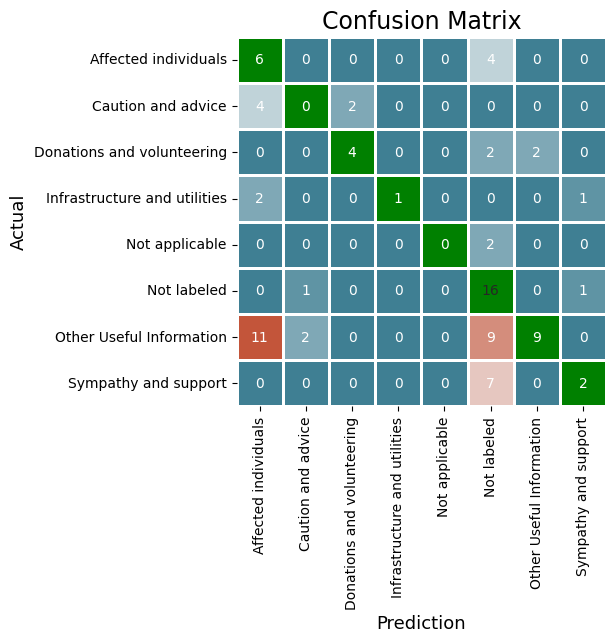

<Figure size 640x480 with 0 Axes>

In [ ]:
# CM for Crisis Type
plt_confusion_matrix(testing_df2['type'],testing_df2['parsed_pred_crisis_type_13'])

[[ 7  1  0  0  0  1  1  0]
 [ 3  3  0  0  0  0  0  0]
 [ 3  1  2  0  0  2  0  0]
 [ 4  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0]
 [ 0  2  0  0  0 11  5  0]
 [18  2  0  0  0  4  7  0]
 [ 0  1  0  0  0  5  0  3]]


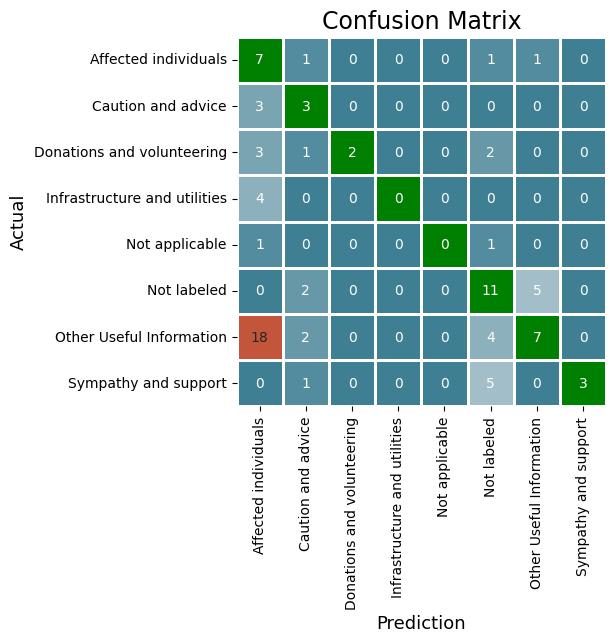

<Figure size 640x480 with 0 Axes>

In [ ]:
# CM for Information Type v9

plt_confusion_matrix(testing_df2['InformationType'],testing_df2['Parsed_Pred_InformationType_Baseline'])

[[ 6  0  0  0  0  4  0  0]
 [ 4  0  2  0  0  0  0  0]
 [ 0  0  4  0  0  2  2  0]
 [ 2  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0 16  0  1]
 [11  2  0  0  0  9  9  0]
 [ 0  0  0  0  0  7  0  2]]


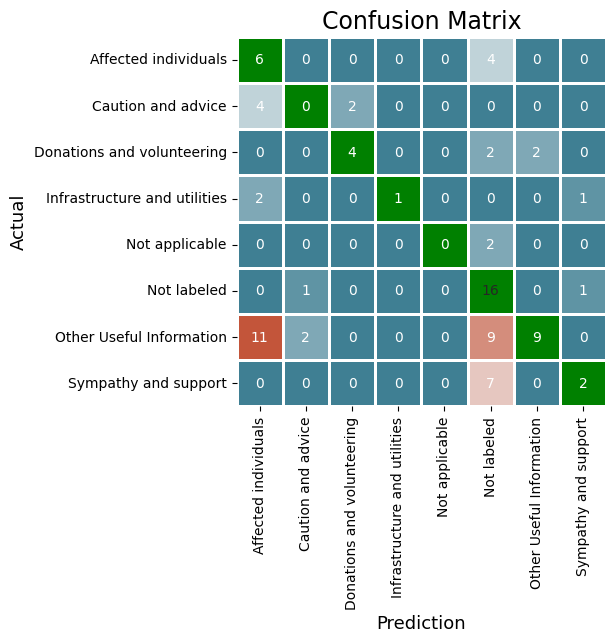

<Figure size 640x480 with 0 Axes>

In [ ]:
# CM for Information Type Basline
plt_confusion_matrix(testing_df2['InformationType'],testing_df2['Parsed_Pred_InformationType_v9'])

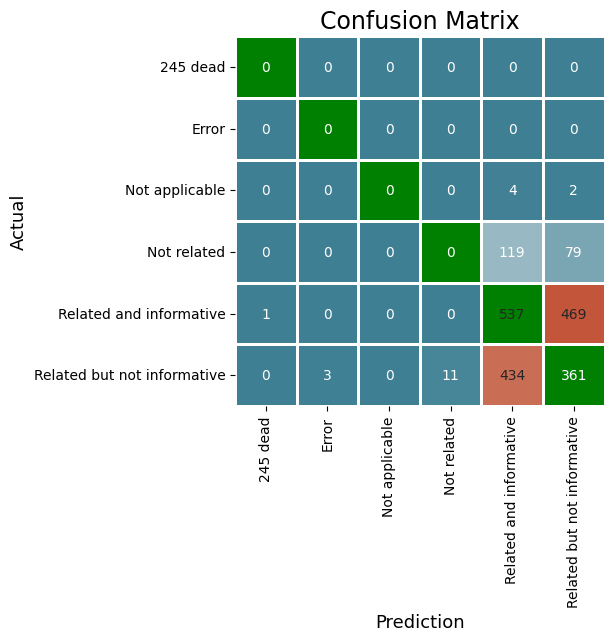

Accuracy: 0.44455445544554456
Precision: 0.40340392444135276
Recall: 0.44455445544554456
F1-score: 0.4229481715065456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [16]:
# CM for Informativeness
plt_confusion_matrix(testing_df['Informativeness'],testing_df['Parsed_Informativeness_pred'])

# Extract the actual and predicted values
actual_values = testing_df['Informativeness']
predicted_values = testing_df['Parsed_Informativeness_pred']

# Calculate accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Calculate precision
precision = precision_score(actual_values, predicted_values, average='weighted')

# Calculate recall
recall = recall_score(actual_values, predicted_values, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_values, predicted_values, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


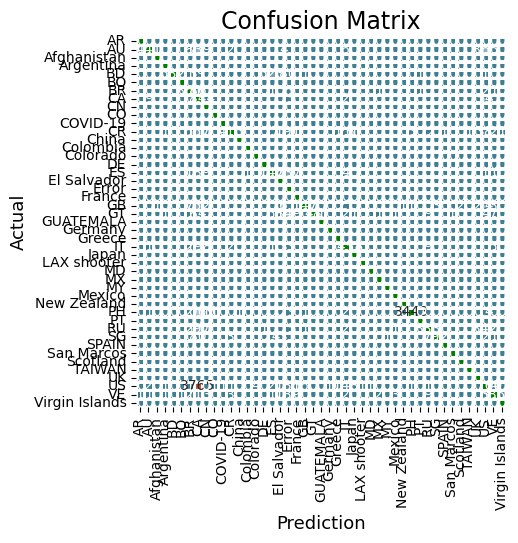

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4926331986920562
Precision: 0.7864566658896365
Recall: 0.4926331986920562
F1-score: 0.5342766631413526


<Figure size 640x480 with 0 Axes>

In [27]:
# CM for Informativeness
plt_confusion_matrix(testing_df['country_code'],testing_df['Parsed_country_pred'])

# Extract the actual and predicted values
actual_values = testing_df['country_code']
predicted_values = testing_df['Parsed_country_pred']

# Calculate accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Calculate precision
precision = precision_score(actual_values, predicted_values, average='weighted')

# Calculate recall
recall = recall_score(actual_values, predicted_values, average='weighted')

# Calculate F1-score
f1 = f1_score(actual_values, predicted_values, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


In [ ]:
# Just a test to view unique values
print(list(np.unique(predicted)))
print(list(np.unique(actual)))
# Number of rows in dataframe
len(testing_df2.index)

['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other Useful Information', 'Sympathy and support']
['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not applicable', 'Not labeled', 'Other Useful Information', 'Sympathy and support']


88

In [ ]:
len(testing_df2.index)

88

# Test

In [ ]:

# Specify the file path for the CSV file you want to read
file_path = '/content/gdrive/MyDrive/iLab2/results-CrisisType6.csv

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)



In [ ]:
df['country'].unique()

array(['Canada', nan, 'Alberta', 'UK', 'Costa Rica', 'Phillipines', 'US',
       'Singapore', 'Russia', 'Chelyabinsk', 'Brazil', 'Bangladesh',
       'Philipinnes', 'Venezuela', 'Italy', 'Spain', 'Australia',
       'Guatemala', 'Sardinia'], dtype=object)

In [ ]:
testing_df['country_code'].unique()

array(['VE', 'Unknown', 'AU', 'BD', 'IT', 'GB', 'US', 'RU', 'GT', 'CA',
       'CR', 'ES', 'BR', 'SG'], dtype=object)